In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter
import math
from scipy.stats.mstats import gmean
from scipy.stats import gamma, poisson, linregress, beta, norm, lognorm
from scipy import optimize
from scipy import interpolate
import time
import random
import pickle as pkl
from craterdata import *
%matplotlib inline

/Users/sam/Library/Python/3.12/lib/python/site-packages/scipy/stats/_distn_infrastructure.py:2027: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


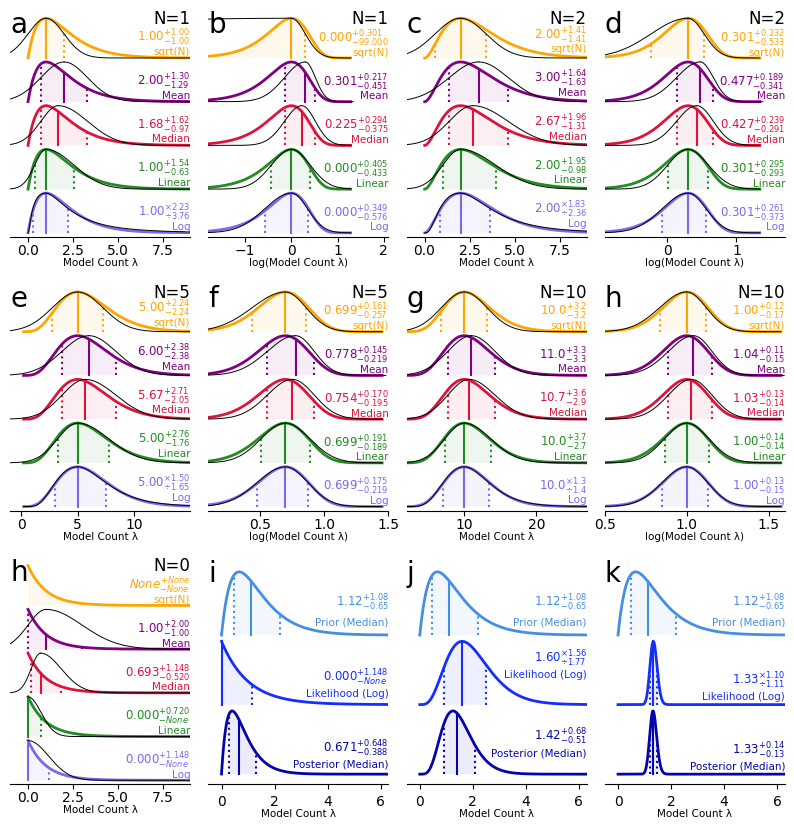

In [2]:
xlim = [-1, 9]
lts = 8.5
pgs = 0

def customized_plotting_parameters(N, letter, xlim=[-1, 9]):
    plt.xlim(xlim)
    plt.ylim(-0.1, 5.5)
    plt.text(
        xlim[0], 1.2 + 1.1 * 4, letter, 
        ha='left', va='top', size=20
    )
    plt.text(
        xlim[1], 1.0 * (1 + 1.1 * 4), 'N=' + str(N), 
        ha='right', va='center', size=12
    )
    ax.tick_params(axis='x', pad=1)

def customized_plot(N, letter, xlim=None, dn=None, lts=lts, pgs=pgs):
    erase_box(plt.gca())
    if dn is not None:
        rounding_n = 1
    else:
        rounding_n = 2
    true_error_pdf(N).plot(
        color='mediumslateblue', label=True, dn=dn, 
        label_text_size=lts, pdf_label='Log', xlim=xlim,
        rounding_n=rounding_n, pdf_gap_shift=pgs
    )
    if N > 0:
        plot_log_of_normal_approximation(N, color='black', linewidth=0.7)
    elif N == 0:
        plot_linear_approximation(
            0, color='black', linewidth=0.7, 
            forced_right_error=N_0_dict['log'][2]
        )
    true_error_pdf(N, kind='linear').plot(
        color='forestgreen', label=True, upshift=1.1, dn=dn,
        label_text_size=lts, pdf_label='Linear', xlim=xlim,
        rounding_n=rounding_n, pdf_gap_shift=pgs
    )
    plot_linear_approximation(N, color='black', linewidth=0.7, upshift=1.1)
    true_error_pdf(N, kind='median').plot(
        color='crimson', label=True, upshift=2 * 1.1, dn=dn,
        label_text_size=lts, pdf_label='Median', xlim=xlim,
        rounding_n=rounding_n, pdf_gap_shift=pgs
    )
    plot_median_approximation(N, color='black', linewidth=0.7, upshift=2.2)
    true_error_pdf(N, kind='mean').plot(
        color='purple', label=True, upshift=3 * 1.1, dn=dn,
        label_text_size=lts, pdf_label='Mean', xlim=xlim,
        rounding_n=rounding_n, pdf_gap_shift=pgs
    )
    val, left, right = get_error_bars(N, kind='Mean', return_val=True)
    plot_approximation(
        val, left, right, color='black', 
        linewidth=0.7, upshift=3.3
    )
    true_error_pdf(N, kind='sqrt(N)').plot(
        color='orange', label=True, upshift=4 * 1.1, dn=dn,
        label_text_size=lts, pdf_label='sqrt(N)', xlim=xlim,
        rounding_n=rounding_n, pdf_gap_shift=pgs
    )
    plot_approximation(
        N, np.sqrt(N), np.sqrt(N), color='black', 
        linewidth=0.7, upshift=4.4
    )
    customized_plotting_parameters(N, letter, xlim=xlim)
    plt.xlabel('Model Count λ', labelpad=0, size=7.5)

def customized_log_plot(
    N, letter, xlim=None, dn=None, pdf_gap_shift=0, lts=lts
):
    erase_box(plt.gca())
    true_error_pdf(N).log().plot(
        color='mediumslateblue', xlim=xlim, label=True, 
        label_text_size=lts, pdf_label='Log', pdf_gap_shift=pdf_gap_shift
    )
    plot_log_of_normal_approximation(
        N, color='black', linewidth=0.7, log_space=True
    )
    true_error_pdf(N, kind='linear').log().plot( 
        color='forestgreen', xlim=xlim, label=True, upshift=1.1,
        label_text_size=lts, pdf_label='Linear', pdf_gap_shift=pdf_gap_shift
    )
    plot_linear_approximation(
        N, color='black', linewidth=0.7, log_space=True, upshift=1.1
    )
    true_error_pdf(N, kind='median').log().plot( 
        color='crimson', xlim=xlim, label=True, upshift=2.2,
        label_text_size=lts, pdf_label='Median', pdf_gap_shift=pdf_gap_shift
    )
    plot_median_approximation(
        N, color='black', linewidth=0.7, log_space=True, upshift=2.2
    )
    true_error_pdf(N, kind='mean').log().plot(
        color='purple', label=True, upshift=3 * 1.1, dn=dn,
        label_text_size=lts, pdf_label='Mean', xlim=xlim,
        pdf_gap_shift=pgs
    )
    val, left, right = get_error_bars(N, kind='Mean', return_val=True)
    plot_approximation(
        val, left, right, color='black', log_space=True,
        linewidth=0.7, upshift=3.3
    )
    if N > 1:
        true_error_pdf(N, kind='sqrt(N)').log().plot(
            color='orange', label=True, upshift=4 * 1.1, dn=dn,
            label_text_size=lts, pdf_label='sqrt(N)', xlim=xlim,
            pdf_gap_shift=pgs
        )
        plot_approximation(
            N, np.sqrt(N), np.sqrt(N), color='black', log_space=True, 
            linewidth=0.7, upshift=4.4
        )
    else:
        one_pdf = true_error_pdf(N, kind='sqrt(N)').cut_below(1E-6)
        one_pdf.low = 1E-99
        one_pdf.log().plot(
            color='orange', label=True, upshift=4 * 1.1, dn=dn,
            label_text_size=lts, pdf_label='sqrt(N)', xlim=xlim,
            pdf_gap_shift=pgs
        )
        plot_approximation(
            N, 1 - 1E-9, np.sqrt(N), color='black', log_space=True, 
            linewidth=0.7, upshift=4.4
        )
    plt.ylim(-0.1, 3.3)
    customized_plotting_parameters(N, letter, xlim=xlim)
    plt.xlabel('log(Model Count λ)', labelpad=0, size=7.5)

fig = plt.figure(figsize=(10, 10))

Ns = [1, 2, 5, 10]
xlims = [xlim, xlim, [-1, 14.99], [2, 27]]
lxls = [[-1.8, 2.1], [-0.9, 1.7], [0.1, 1.5], [0.5, 1.6]]

letter_count = 0
for i in range(4):
    N = Ns[i]
    
    letter = chr(ord('a') + letter_count)
    ax = fig.add_subplot(3, 4, letter_count + 1)
    letter_count += 1
    customized_plot(N, letter, xlim=xlims[i])
    
    letter = chr(ord('a') + letter_count)
    ax = fig.add_subplot(3, 4, letter_count + 1)
    customized_log_plot(N, letter, xlim=lxls[i])
    letter_count += 1
    
ax = fig.add_subplot(3, 4, 9)
customized_plot(0, letter, xlim=xlim)

def customized_prior_plot(
    N, letter, division_factor=1.0, xlim=[-0.5, 6.3], 
    m_prior=3.5, m_likelihood=3.1, m_posterior=2.5, ppgs=-0.05,
    llsy=0, lts=lts
):
    erase_box(plt.gca())
    prior = true_error_pdf(1) / 1.5
    likelihood = (true_error_pdf(N) / division_factor).match_X_of(prior)
    posterior = prior.update(likelihood).as_kind('median')
    lsy = prior.standardize()[m_prior] + 0.02
    prior.as_kind('median').plot(
        color=cs[0], upshift=1.1 * 2, label=True, label_text_size=lts,
        pdf_label='Prior (Median)', xlim=xlim, label_shift_y=lsy
    )
    lsy = likelihood.standardize()[m_likelihood] + 0.02 + llsy
    likelihood.plot(
        color=cs[1], upshift=1.1 * 1, label=True, label_text_size=lts,
        pdf_label='Likelihood (Log)', xlim=xlim, label_shift_y=lsy,
        pdf_gap_shift=ppgs
    )
    lsy = posterior.standardize()[m_posterior] + 0.02
    posterior.plot(
        color=cs[2], label=True, label_text_size=lts,
        pdf_label='Posterior (Median)', xlim=xlim, label_shift_y=lsy,
        pdf_gap_shift=ppgs
    )
    plt.text(xlim[0], 1.2 + 1.1 * 2, letter, ha='left', va='top', size=20)
    plt.xlabel('Model Count λ', labelpad=0, size=7.5)

for i, N, df in zip(
    range(10, 13), [0, 4, 100], [1, 2.5, 75]
):
    letter = chr(ord('a') + letter_count)
    ax = fig.add_subplot(3, 4, i)
    customized_prior_plot(N, letter, division_factor=df)
    letter_count += 1

plt.subplots_adjust(wspace=0.1, hspace=0.23)
pfig = plt.gcf()
pfig.savefig('figs/prior_explanation.pdf', bbox_inches='tight')

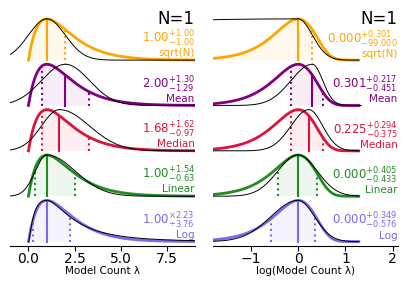

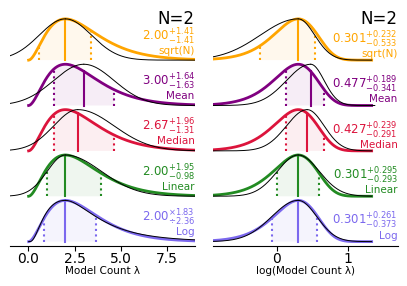

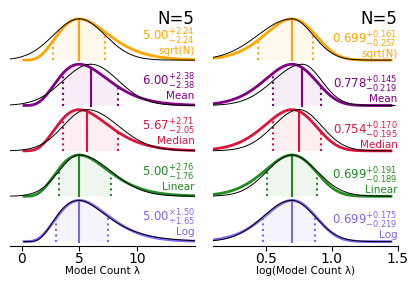

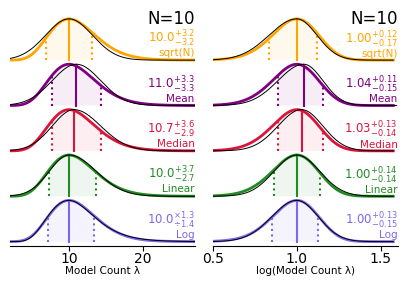

In [3]:
Ns = [1, 2, 5, 10]
xlims = [xlim, xlim, [-1, 14.99], [2, 27]]
lxls = [[-1.8, 2.1], [-0.9, 1.7], [0.1, 1.5], [0.5, 1.6]]
letter_count = 0
for i in range(len(Ns)):
    N = Ns[i]
    letter = chr(ord('a') + letter_count)
    letter_count += 1
    fig = plt.figure(figsize=(5, 3))
    if N == 0:
        ax = fig.add_subplot(111)
        customized_plot(N, '', xlim=xlims[i])
    else:
        ax = fig.add_subplot(121)
        customized_plot(N, '', xlim=xlims[i])
        ax = fig.add_subplot(122)
        customized_log_plot(N, '', xlim=lxls[i])
    plt.subplots_adjust(wspace=0.1, hspace=0.28)
    pfig = plt.gcf()
    pfig.savefig(
        'figs/error_bar_comparison_plot_N' + str(N) + '.pdf', 
        bbox_inches='tight'
    )

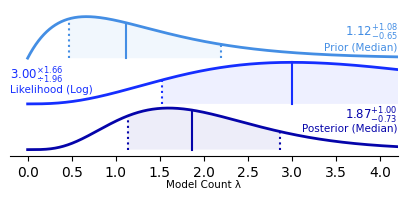

In [4]:
fig = plt.figure(figsize=(5, 1.9))
ax = fig.add_subplot(111)
N = 3
customized_prior_plot(
    N, '', division_factor=1, xlim=[-0.2, 4.2], ppgs=-0.02,
    m_prior=0.0005, m_likelihood=0.5, m_posterior=0.4
)
pfig = plt.gcf()
pfig.savefig(
    'figs/PDF_comparison_plot_N' + str(N) + '.pdf', 
    bbox_inches='tight'
)

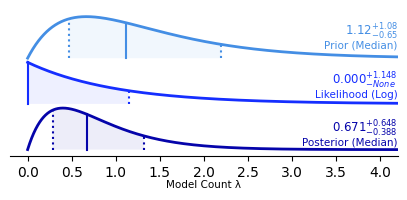

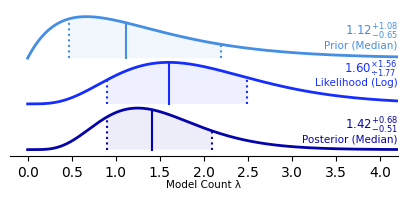

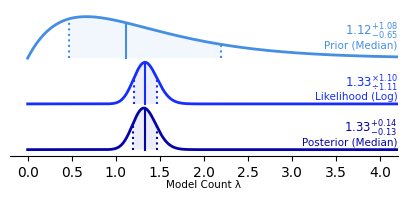

In [5]:
for N, i, df in zip([0, 4, 100], range(14, 17), [1, 2.5, 75]):
    fig = plt.figure(figsize=(5, 1.9))
    ax = fig.add_subplot(111)
    if i == 15:
        llsy = -0.07
    else:
        llsy = 0
    customized_prior_plot(
        N, '', division_factor=df, xlim=[-0.2, 4.2], ppgs=-0.02,
        m_prior=4.1, m_likelihood=4.2, m_posterior=3.2
    )
    pfig = plt.gcf()
    pfig.savefig(
        'figs/PDF_comparison_plot_N' + str(N) + '.pdf', 
        bbox_inches='tight'
    )